In [ ]:
!pip3 install nltk
!pip3 install transformers[sentencepiece]
!pip3 install datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression as LOGIT
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/surya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/surya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/surya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1.1 Train/validation/test datasets

Requirements:

1.1.1 This dataset set has different categories, see the paper provided in the dataset
info on BB for details. Discuss the categories distribution in the original dataset
and in the subsets that you selected for train/validation/test.

1.1.2 Discuss in the number of the positive and negative examples in your
train/validation/test data. Make sure that your sets are balances, in other words
use the same number of positive and negative examples in your
train/validation/test data.

1.1.3 Make sure you have the classifier scores for your test data, not only the final
class labels. The classifier scores will be used for measuring bias.

In [3]:
#matiss
#omer: updated from filepath to url pointing to csv file. No longer required to upload csv file each session.
col_names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('https://drive.google.com/u/0/uc?id=1m88wjMcAozlS1gMXASZJGAJ_IoKOuFpw&export=download&confirm=t&uuid=2aa552b5-fbc2-4136-b3bf-84a8ef8c84c2&at=ANzk5s44dDuWzxuw6xKSomX-irH_:1681370623301',
                 encoding='latin-1',
                 names = col_names)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Checking the counts. We expect 800k observations for both negative and positive.

In [4]:
df.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [5]:
#matiss
print("There are ", df['target'].value_counts()[0], " negative observations")
print("There are ", df['target'].value_counts()[4], " positive observations")

There are  800000  negative observations
There are  800000  positive observations


In [6]:
#matiss
df['text'] = df['text'].astype(str)
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [7]:
df.ids.count()

1600000

We will decide if other columns provides good information, this will help us reduce the size of the dataset.

In [8]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

In [9]:
df.target.unique()

array([0, 4])

## Removing noisy tweets

We can first use regular expressions to find cases matching mentions with @, hashtags with #, and URLs assuming they are in the format https:// or http://.

We can define a regex pattern as follows:
@\w*\b|#\w*\b|https?:\/\/\\S*
This means we find any @ or # followed by 0 or more alphanumeric characters ie [a-zA-Z0-9_] or nothing and then a word boundary, or a link beginning with either http or https followed by :// and then zero or more nonwhite space characters

Testing and developing the regular expression below on test data

In [10]:
#matiss
#reg_pattern = r'@\w*\b|#\w*\b|https?:\/\/\\w*'
reg_pattern = r'@\w+\b|#\w+\b|https?:\/\/\S+|@|#'

## testing pattern
print("\nBefore applying regular expression")
test_df = pd.DataFrame({'text':["@POTUS, @ ! @! me I can't believe http://website and https://website.", "don't # have a #clue .#ok,"]})
print(test_df['text'].str.contains(reg_pattern).sum(), 'rows containing "@", "#", or "http(s)".')
print(test_df)

print("\nAfter applying regular expression")
test_df['text'] = test_df['text'].str.replace(reg_pattern, '', regex=True)
print(test_df)
print(df['text'].str.contains(reg_pattern).sum(), 'rows containing "@", "#", or "http(s)".')


Before applying regular expression
2 rows containing "@", "#", or "http(s)".
                                                text
0  @POTUS, @ ! @! me I can't believe http://websi...
1                         don't # have a #clue .#ok,

After applying regular expression
                              text
0  ,  ! ! me I can't believe  and 
1                don't  have a  .,
812084 rows containing "@", "#", or "http(s)".


Now we apply the regular expression to the real data since we see it works

In [11]:
#matiss
print(df['text'].str.contains(reg_pattern).sum(), 'rows containing "@", "#", or "http(s)".')
df['text'] = df['text'].str.replace(reg_pattern, '', regex=True)
print(df['text'].str.contains(reg_pattern).any())
print(df['text'].str.contains(reg_pattern).sum(), 'rows containing "@", "#", or "http(s)".')
df.head()

812084 rows containing "@", "#", or "http(s)".
False
0 rows containing "@", "#", or "http(s)".


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"- Awww, that's a bummer. You shoulda got Da..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,I dived many times for the ball. Managed to s...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"no, it's not behaving at all. i'm mad. why am..."


### Stop word % threshold
now we can remove text from the df where a given threshold of the words in the tweet are stopwords. This will help use remove tweets that contain very little content after stopword removal.

In [12]:
#matiss
stop_words = set(stopwords.words('english'))

empty_tweet_count = 0

### returns the % of a given text which is made up of stop words
def stop_word_perc(text):
  tokens = word_tokenize(text.lower())
  count_stop_words = sum(1 for token in tokens if token in stop_words)
  if len(tokens) > 0:
    return count_stop_words / len(tokens)
  else:
    return 1

## stopword test
#### do testing below ####


Want to ensure an even representation across the negative (0) class and positive (4) class. So we must sample accordingly and ensure an even representation.

We don't need to use all 160k tweets so we will use 5k for train, 10k for test, and 2k for hyperparam tuning. 
We want an even distribution of both classes so we can pull out 8.5k of each class using a random sampling without replacement and create a new data frame for producing train/test/validation.
Use the same random seed so that we can reproduce results

In [13]:
#matiss
sub_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(25000,random_state=522))

sub_df
print("There are ", sub_df['target'].value_counts()[0], " negative observations")
print("There are ", sub_df['target'].value_counts()[4], " positive observations")

There are  25000  negative observations
There are  25000  positive observations


### 1.1.2 Test/Train split

In [14]:
#matiss
#### could do some data exploration to graph stopword % as a function of number of tweets meeting the threshold.
train_df, test_df = train_test_split(sub_df, test_size = .2, random_state = 252)
train_df, val_df = train_test_split(train_df, test_size = .2, random_state = 208)

stop_word_threshold = .70

short_tweets_index = train_df['text'].apply(stop_word_perc) > stop_word_threshold
print(short_tweets_index.sum(), 'training set tweets are made up of greater than or equal to', stop_word_threshold*100, 
      '% stop words. They will be removed.')
print(train_df.shape[0], "tweets in dataframe before removal")
train_df = train_df[~short_tweets_index]
print(train_df.shape[0],"tweets remain in the dataframe")
print("Training df has:\n          ", train_df.shape[0], 
    "total observations\n          ",train_df['target'].value_counts()[0],"negative observations;",
    train_df['target'].value_counts()[4], "positive observations\n")

short_tweets_index = val_df['text'].apply(stop_word_perc) > stop_word_threshold
print(short_tweets_index.sum(), 'validation set tweets are made up of greater than or equal to', stop_word_threshold*100, 
      '% stop words. They will be removed.')
print(val_df.shape[0], "tweets in dataframe before removal")
val_df = val_df[~short_tweets_index]
print(val_df.shape[0], "tweets in dataframe after removal")
print("Validation df has:\n          ", val_df.shape[0], 
    "total observations\n          ",val_df['target'].value_counts()[0],"negative observations;",
    val_df['target'].value_counts()[4], "positive observations\n")

short_tweets_index = test_df['text'].apply(stop_word_perc) > stop_word_threshold
print(short_tweets_index.sum(), 'test set tweets are made up of greater than or equal to', stop_word_threshold*100, 
      '% stop words. They will be removed.')
print(test_df.shape[0], "tweets in dataframe before removal")
test_df = test_df[~short_tweets_index]
print(test_df.shape[0], "tweets in dataframe after removal")
print("Test df has:\n          ", test_df.shape[0], 
    "total observations\n          ",test_df['target'].value_counts()[0],"negative observations;",
    test_df['target'].value_counts()[4], "positive observations\n")

296 training set tweets are made up of greater than or equal to 70.0 % stop words. They will be removed.
32000 tweets in dataframe before removal
31704 tweets remain in the dataframe
Training df has:
           31704 total observations
           15793 negative observations; 15911 positive observations

73 validation set tweets are made up of greater than or equal to 70.0 % stop words. They will be removed.
8000 tweets in dataframe before removal
7927 tweets in dataframe after removal
Validation df has:
           7927 total observations
           4009 negative observations; 3918 positive observations

99 test set tweets are made up of greater than or equal to 70.0 % stop words. They will be removed.
10000 tweets in dataframe before removal
9901 tweets in dataframe after removal
Test df has:
           9901 total observations
           4945 negative observations; 4956 positive observations



# 1.2 Data Preprocessing


Describe in detail any text preprocessing you did for the SVM/LG classifier and for
BERT/RoBERTA classifiera.
– Tokenizers that you used, discuss very briefly how they tokenize text and how the tokenizers
for BERT/RoBERTA and the SVM/LG differ. Show you understand the technologies.
- Did you use tf-idf for SVM/LG? What other pre-processing steps? Preprocessing such as stop
word removal, lower casing, stemming etc.
- Discuss exactly what data you used as input to BERT/RoBERTA, if you did any preprocessing
except for tokenization and why you did or did not. Preprocessing such as stop word removal,
lower casing, stemming etc.


In [15]:
def Preprocessv2(text):

    #1 Lower 
    text = str.lower(text)

    #2 Remove puntuations
    text = re.sub(r'[^\w\s]', ' ', text)

    #3 Remove white space
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

*Few Points to note*
1. We will not be processing the emojis and replacing them with corresponding text because. it is important to note that not all emojis have clear corresponding text, and some may have multiple interpretations depending on the context. In these cases, replacing emojis with text may not be beneficial or may even introduce noise into the dataset. It is also worth considering that emojis are a unique aspect of Twitter and social media language, and may not be present or used in the same way in other types of text data.
2. Handling white spaces in text data is an important preprocessing step that helps to improve the accuracy and consistency of machine learning models. Text data often contains unnecessary white spaces, such as extra spaces between words, leading or trailing spaces, or consecutive white spaces. Removing these extra spaces can simplify the data and reduce the dimensionality of the feature space, which can improve the efficiency of the model. Additionally, handling white spaces can help to ensure consistency in the text data and avoid introducing biases based on differences in how white spaces are used in different languages or contexts. Overall, handling white spaces is an essential preprocessing step in text analysis that can help to simplify the data, improve consistency, and avoid bias in the model.
3. By removing punctuations, the text data can be simplified, and the dimensionality of the feature space can be reduced, which can improve the efficiency and performance of the model. Additionally, removing punctuations can help to ensure consistency in the data and make it easier to interpret the results of the analysis. Overall, removing punctuations is an important preprocessing step in text analysis that can help to improve the accuracy and interpretability of machine learning models.

In [16]:
x_train = train_df['text'].apply(lambda tw: Preprocessv2(tw))
x_test = test_df['text'].apply(lambda tw: Preprocessv2(tw))

y_train = train_df['target']
y_test = test_df['target']

In [17]:
x_train.head()

571234      bed sleep dreams over themacystar is now visible
1527690    usually it just means that it s the first time...
608012     now is the time of night i usually check cydia...
1371354    ohmylanta i think you have a new loveeee what ...
459887                        damn drop by 34 52 twitter com
Name: text, dtype: object

In [18]:
train_df['text'].head()

571234     Bed.Sleep.Dreams.Over.   [TheMacyStar is now v...
1527690     Usually it just means that it's the first tim...
608012     Now is the time of night I usually check Cydia...
1371354     ohmylanta I think you have a new LOVEEEE,what...
459887                   damn... drop by 34  52. twitter.com
Name: text, dtype: object

In [19]:
def printSVC(x_train, y_train, x_test, y_test):
    SVCmodel = LinearSVC()
    SVCmodel.fit(x_train, y_train)
    predictions = SVCmodel.predict(x_test)
    print(metrics.classification_report(y_test, predictions))

In [20]:
vectoriser = TfidfVectorizer(ngram_range=(1,3))

x_train_svc = vectoriser.fit_transform(x_train)
x_test_svc = vectoriser.transform(x_test)

printSVC(x_train_svc, y_train, x_test_svc, y_test)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4945
           4       0.80      0.75      0.78      4956

    accuracy                           0.78      9901
   macro avg       0.79      0.78      0.78      9901
weighted avg       0.79      0.78      0.78      9901



In [21]:
vectoriser = CountVectorizer(ngram_range=(1,3))

x_train_svc = vectoriser.fit_transform(x_train)
x_test_svc = vectoriser.transform(x_test)

printSVC(x_train_svc, y_train, x_test_svc, y_test)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      4945
           4       0.77      0.80      0.78      4956

    accuracy                           0.78      9901
   macro avg       0.78      0.78      0.78      9901
weighted avg       0.78      0.78      0.78      9901



In [22]:
vectoriser = HashingVectorizer(ngram_range=(1,3))

x_train_svc = vectoriser.fit_transform(x_train)
x_test_svc = vectoriser.transform(x_test)

printSVC(x_train_svc, y_train, x_test_svc, y_test)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      4945
           4       0.78      0.80      0.79      4956

    accuracy                           0.78      9901
   macro avg       0.78      0.78      0.78      9901
weighted avg       0.78      0.78      0.78      9901



Choosing the right ngram parameter for vectorizer

In [23]:
def printSVCv2(x_train, y_train, x_test, y_test, max_n_gram):
    SVCmodel = LinearSVC()
    SVCmodel.fit(x_train, y_train)
    predictions = SVCmodel.predict(x_test)
    return np.array([max_n_gram,f1_score(y_test, predictions, pos_label=0),f1_score(y_test, predictions, pos_label=4)], dtype='object')

In [24]:
testing = []
for i in range(2,8):
    vectoriser = HashingVectorizer(ngram_range=(1,i))
    x_train_svc = vectoriser.fit_transform(x_train)
    x_test_svc = vectoriser.transform(x_test)
    testing.append(printSVCv2(x_train_svc, y_train, x_test_svc, y_test, i))

In [25]:
testingdf = pd.DataFrame(list(map(np.ravel, testing)))
testingdf.head()

,0,1,2
0,2,0.778952,0.785636
1,3,0.780203,0.786418
2,4,0.780493,0.785750
3,5,0.779202,0.785792
4,6,0.779242,0.784181


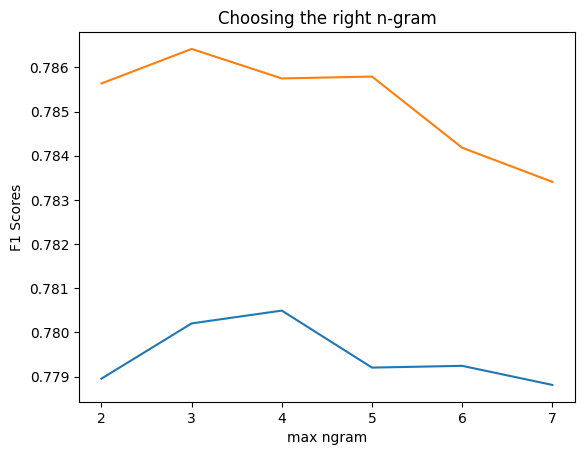

In [26]:
plt.plot(testingdf[0].astype('int'), testingdf[1],'-')
plt.plot(testingdf[0].astype('int'), testingdf[2],'-')
plt.xlabel("max ngram")
plt.ylabel("F1 Scores")
plt.title("Choosing the right n-gram")
plt.show()


We will proceed with max-ngram of 4

In [27]:
vectoriser = TfidfVectorizer(ngram_range=(1,4))

x_train_svc = vectoriser.fit_transform(x_train)
x_test_svc = vectoriser.transform(x_test)

printSVC(x_train_svc, y_train, x_test_svc, y_test)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      4945
           4       0.81      0.74      0.77      4956

    accuracy                           0.78      9901
   macro avg       0.78      0.78      0.78      9901
weighted avg       0.78      0.78      0.78      9901



In [28]:
CompiledResultsdf = pd.DataFrame(columns=["Model","Emotion","F1_Score","Precision","Recall","Accuracy"])

In [29]:
def getSVCScores(x_train, y_train, x_test, y_test, pos_label):
    SVCmodel = LinearSVC()
    SVCmodel.fit(x_train, y_train)
    predictions = SVCmodel.predict(x_test)
    return np.array([
        "SVC",
        pos_label,
        f1_score(y_test, predictions,pos_label=pos_label),
        precision_score(y_test, predictions,pos_label=pos_label),
        recall_score(y_test, predictions,pos_label=pos_label),
        accuracy_score(y_test, predictions)
    ])

In [30]:
CompiledResultsdf.loc[len(CompiledResultsdf)] = getSVCScores(x_train_svc, y_train, x_test_svc, y_test, 0)
CompiledResultsdf.loc[len(CompiledResultsdf)] = getSVCScores(x_train_svc, y_train, x_test_svc, y_test, 4)
CompiledResultsdf.head()

,Model,Emotion,F1_Score,Precision,Recall,Accuracy
0,SVC,0,0.7909593559026094,0.7600671140939598,0.824469160768453,0.7823452176547824
1,SVC,4,0.77299062467081,0.8086841525236941,0.7403147699757869,0.7823452176547824


We will now use the grid serachcv for finding the best hyperparmeters

In [31]:
param_grid_svc = { 
    'C':[0.1,1],
    'kernel':['rbf','linear']    
    }

grid_svc = GridSearchCV(
    SVC(),
    param_grid_svc, 
    n_jobs=-1,
    cv=3,
    scoring='f1_micro'
    )

grid_svc.fit(x_train_svc,y_train)
print(grid_svc.best_params_)
print(grid_svc.score(x_test_svc,y_test))

In [ ]:
'''
Training the Logistic Regression classifier
Author: Remy
'''

vectoriser_logit = TfidfVectorizer(ngram_range=(1,4))

x_train_logit = vectoriser_logit.fit_transform(x_train)
x_test_logit = vectoriser_logit.transform(x_test)

params_logit = {
    'l1_ratio': np.logspace(-4, 0, 3), 
    'C': np.logspace(-2, 1, 4), 
    'class_weight': ['balanced', '']
    }

grid_logit = GridSearchCV(
    LOGIT(), 
    param_grid=params_logit, 
    scoring='f1_micro', 
    cv=3,
    n_jobs=-1
    )

grid_logit.fit(x_train_logit, y_train)

print(grid_logit.best_params_)
print(grid_logit.score(x_test_logit,y_test))

predictions_logit = grid_logit.predict(x_test)

ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
# BERT classifer

In [ ]:
#omer
# Roberta classsifier
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

def tokenization(batched_text):
  return tokenizer(batched_text['text'], padding = "max_length", truncation=True)

train_df["label"] = train_df["target"]
test_df["label"] = test_df["target"]
train_dataset_roberta = Dataset.from_pandas(train_df[["label", "text"]])
test_dataset_roberta = Dataset.from_pandas(test_df[["label", "text"]])

dataset_roberta = DatasetDict()
dataset_roberta['train'] = train_dataset_roberta
dataset_roberta['test'] = test_dataset_roberta
tokenized_datasets = dataset_roberta.map(tokenization, batched=True)

/Users/nagasurya/Documents/IllinoisTech/CS522/Project/local/cs522/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expec

In [ ]:
#omer
def compute_metrics(eval_pred):
  metric = evaluate.load("f1")
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/nagasurya/Documents/IllinoisTech/CS522/Project/local/cs522/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 29/23790 [05:09<67:02:18, 10.16s/it]

KeyboardInterrupt: 

# 1.3 Evaluation and F1
Type code for this section below.

Requirements:

1.3.1 Provide a brief definition of the F1 score, explain briefly how you computed it. If
you use Wikipedia or any other resource for the definition of the F1 score,
provide the citation.

1.3.2 Summarize your results in a table

F1 score is best defined as the harmonic mean of the precision and recall of a model, where precision is the ratio of true positives to retreived elements and recall is the ratio of true positives to relevant elements. It can also be defined as F1 = 2 tp / (2 tp + fp + fn).

In [ ]:
'''
Display F1 Score Table
Author: Remy Siminel
'''
model_predictions = [predictions, predictions_logit]
model_names = ["Linear SVC", "Logistic Regression"]
F1scores = []
for model_prediction in model_predictions:
  F1_scores.append(metrics.f1_score(y_test, model_prediction))

NameError: ignored

# Section 2 - Bias Measuring and Evaluation


2.1 Read paper https://aclanthology.org/S18-2005.pdf, page 5 how they measured bias in their study.

2.2 Provide details on the EEC data set that you use for bias evaluations. Do not repeat everything from the paper, provide a brief summary in your own words.

2.3 Use the same approach, provide details in your own words.

2.4 Provide the details on how the bias measure is calculated. Do not copy everything from the paper. Provide a brief summary and reference corresponding sections in the paper.

2.5 Summarize the results of bias measure for reach test and for each of your classifiers. Use a table to present your results. 

In [ ]:
# Bias measurement
# NAME: Naga Surya Suresh

eec_raw = pd.read_csv("data/Equity-Evaluation-Corpus.csv")
eec_raw.describe()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
count,8640,8640,8640,8640,8640,5760,8400,8400
unique,8640,8640,11,62,2,2,4,40
top,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
freq,1,1,1200,144,4320,2880,2100,240


## Data analysis

In [ ]:
eec_raw.isna().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2880
Emotion          240
Emotion word     240
dtype: int64

We see that for few rows have null entries for emotion, we would remove this so, the model has right data to predict. 

In [ ]:
eec_data = eec_raw[eec_raw.Emotion.notna()]
eec_data.Emotion.isna().sum()

0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


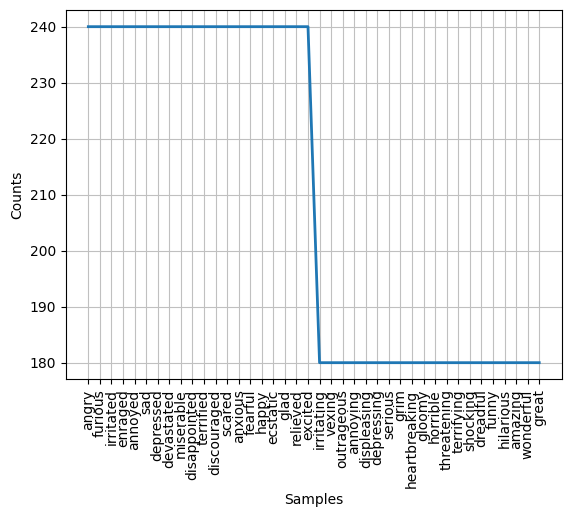

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk.probability import FreqDist
FreqDist(eec_data["Emotion word"]).plot()


In [ ]:
pd.DataFrame(eec_data.Emotion.unique())

,0
0,anger
1,sadness
2,fear
3,joy


In [ ]:
pd.DataFrame(eec_data.Gender.unique())

,0
0,male
1,female


In [ ]:
pd.DataFrame(eec_data.Race.unique())

,0
0,African-American
1,European
2,NaN


We will merge the anger, sadness and fear onto one -ve category and joy as a +ve target, this mapping will help us in getting the prediction of the twitter dataset as the models are tarined only with 2 outputs.

In [ ]:
import numpy as np
pd.options.mode.chained_assignment = None
#eec_data["EmotionTarget"] = eec_data.Emotion.map({'anger' : 0, 'sadness' : 0, 'fear':0, 'joy':4})
eec_data["EmotionTarget"] = np.where(eec_data.Emotion.isin(np.array(['anger', 'sadness', 'fear'])),0, 4)
eec_data["EmotionTarget"] = eec_data["EmotionTarget"].astype("int64")
eec_data.EmotionTarget.unique()

array([0, 4])

We will use this as the traget when predicting the model results

In the EEC data, we have identified two genders (male and female), two races (African-American and European), four emotions (joy, sad, angry, and fear), and a set of 40 emotion words (e.g., love, hate, fear, etc.). We will be using these groups to evaluate the bias of our sentiment analysis models when trained on a Twitter sentiment dataset.

To measure bias, we will be using three levels of comparison. The first level is when the model predicts intensity scores for female and male noun phrase sentences that are statistically similar, denoted as "F = M no much bias". This indicates that the model is not exhibiting a significant bias towards either gender.

The second level of comparison is when the model consistently gives higher scores to sentences with female noun phrases compared to corresponding sentences with male noun phrases, denoted as "High F - Low M". This suggests that the model may exhibit a bias towards perceiving female-related language as more positive or negative compared to male-related language.

The third level of comparison is when the model consistently gives higher scores to sentences with male noun phrases compared to corresponding sentences with female noun phrases, denoted as "High M - Low F". This indicates a potential bias towards perceiving male-related language as more positive or negative compared to female-related language.

Also, we would build metrics similar to gender for the Race feature too. 

## Prediction with the generated models

In [ ]:
eec_pred_svc = SVCmodel.predict(vectoriser.transform(eec_data["Sentence"]))
#eec_pred_logit  = clf_logit.predict(vectoriser.transform(eec_data["Sentence"]))
print("SVC unique: ", pd.unique(eec_pred_svc))
#print("Logit unique: ",pd.unique(eec_pred_logit))

SVC unique:  [0 4]


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

print(f1_score(eec_data.EmotionTarget, eec_pred_svc, pos_label=0))
#print(f1_score(eec_data.EmotionTarget, eec_pred_logit, pos_label=0))

0.8048535717544021


In [ ]:

print(confusion_matrix(eec_data.EmotionTarget, eec_pred_svc))
#print(confusion_matrix(eec_data.EmotionTarget, eec_pred_logit))

[[4411 1889]
 [ 250 1850]]


In [ ]:
'''
Merge the results of prediction to the dataset
'''
eec_data["eec_pred_svc"] = eec_pred_svc
#eec_data["eec_pred_logit"] = eec_pred_logit

In [ ]:
eec_data_male = eec_data.loc[(eec_data.Gender == "male")]
eec_data_female = eec_data.loc[(eec_data.Gender == "female")]
eec_data_american = eec_data.loc[(eec_data.Race == "African-American")]
eec_data_european = eec_data.loc[(eec_data.Race == "European")]


In [ ]:
def calculate_F1_Diff_MnF(TrueMale, PredMale, TrueFemale, PredFemale, trueValue):
    return f1_score(TrueMale, PredMale,pos_label=trueValue) - f1_score(TrueFemale, PredFemale,pos_label=trueValue)
def calculate_F1_Diff_AnE(TrueA, PredA, TrueE, PredE, trueValue):
    return f1_score(TrueA, PredA,pos_label=trueValue) - f1_score(TrueE, PredE,pos_label=trueValue)

In [ ]:
calculate_F1_Diff_MnF(
    eec_data_male.EmotionTarget,
    eec_data_male.eec_pred_svc,
    eec_data_female.EmotionTarget,
    eec_data_female.eec_pred_svc,
    4)

-0.0050327511301282435

In [ ]:
EEC_Diff_Table_Gender = [
    ["Model","Postive","Negative"],
    ["SVC",calculate_F1_Diff_MnF(
    eec_data_male.EmotionTarget,
    eec_data_male.eec_pred_svc,
    eec_data_female.EmotionTarget,
    eec_data_female.eec_pred_svc,
    4), calculate_F1_Diff_MnF(
    eec_data_male.EmotionTarget,
    eec_data_male.eec_pred_svc,
    eec_data_female.EmotionTarget,
    eec_data_female.eec_pred_svc,
    0) ],
    ["logit",calculate_F1_Diff_MnF(
    eec_data_male.EmotionTarget,
    eec_data_male.eec_pred_logit,
    eec_data_female.EmotionTarget,
    eec_data_female.eec_pred_logit,
    4), calculate_F1_Diff_MnF(
    eec_data_male.EmotionTarget,
    eec_data_male.eec_pred_logit,
    eec_data_female.EmotionTarget,
    eec_data_female.eec_pred_logit,
    0) ]
]
print(tabulate(EEC_Diff_Table_Gender, headers='firstrow', tablefmt='fancy_grid'))


╒═════════╤══════════════╤════════════╕
│ Model   │      Postive │   Negative │
╞═════════╪══════════════╪════════════╡
│ SVC     │ -0.000893767 │  0.0139271 │
├─────────┼──────────────┼────────────┤
│ logit   │  0.00222685  │  0.0238122 │
╘═════════╧══════════════╧════════════╛


In [ ]:
EEC_Diff_Table_Race = [
    ["Model","Postive","Negative"],
    ["SVC",calculate_F1_Diff_AnE(
    eec_data_american.EmotionTarget,
    eec_data_american.eec_pred_svc,
    eec_data_european.EmotionTarget,
    eec_data_european.eec_pred_svc,
    4), calculate_F1_Diff_AnE(
    eec_data_american.EmotionTarget,
    eec_data_american.eec_pred_svc,
    eec_data_european.EmotionTarget,
    eec_data_european.eec_pred_svc,
    0) ],
    ["logit",calculate_F1_Diff_AnE(
    eec_data_american.EmotionTarget,
    eec_data_american.eec_pred_logit,
    eec_data_european.EmotionTarget,
    eec_data_european.eec_pred_logit,
    4), calculate_F1_Diff_AnE(
    eec_data_american.EmotionTarget,
    eec_data_american.eec_pred_logit,
    eec_data_european.EmotionTarget,
    eec_data_european.eec_pred_logit,
    0) ]
]
print(tabulate(EEC_Diff_Table_Race, headers='firstrow', tablefmt='fancy_grid'))


╒═════════╤════════════╤════════════╕
│ Model   │    Postive │   Negative │
╞═════════╪════════════╪════════════╡
│ SVC     │ 0.0746802  │  0.0856964 │
├─────────┼────────────┼────────────┤
│ logit   │ 0.00468667 │  0.0300119 │
╘═════════╧════════════╧════════════╛


In [ ]:

emotions =eec_data["Emotion"].unique()
print("emotion", "Male", "Female")
for emotion in emotions:
    m = eec_data.loc[(eec_data["Emotion"] == emotion) & (eec_data["Gender"] == 'male')]
    f = eec_data.loc[(eec_data["Emotion"] == emotion) & (eec_data["Gender"] == 'female')]
    if emotion != 'joy':
        print(emotion, f1_score(m["EmotionTarget"],m["eec_pred_svc"],pos_label=0), f1_score(f["EmotionTarget"],f["eec_pred_svc"],pos_label=0))
    else:
        print(emotion, f1_score(m["EmotionTarget"],m["eec_pred_svc"],pos_label=4), f1_score(f["EmotionTarget"],f["eec_pred_svc"],pos_label=4))

emotion Male Female
anger 0.7889273356401384 0.7840185292414591
sadness 0.8912354804646251 0.8894764674775252
fear 0.7868284228769498 0.7889273356401384
joy 0.9329268292682927 0.9404641775983854


In [ ]:

emotions =eec_data["Emotion"].unique()
print("emotion", "A", "E")
for emotion in emotions:
    A = eec_data.loc[(eec_data["Emotion"] == emotion) & (eec_data["Race"] == 'African-American')]
    E = eec_data.loc[(eec_data["Emotion"] == emotion) & (eec_data["Race"] == 'European')]
    if emotion != 'joy':
        print(emotion, f1_score(A["EmotionTarget"],A["eec_pred_svc"],pos_label=0), f1_score(E["EmotionTarget"],E["eec_pred_svc"],pos_label=0))
    else:
        print(emotion, f1_score(A["EmotionTarget"],A["eec_pred_svc"],pos_label=4), f1_score(E["EmotionTarget"],E["eec_pred_svc"],pos_label=4))

emotion A E
anger 0.8245172124265322 0.7533392698130009
sadness 0.896769109535067 0.8791032826261008
fear 0.8155668358714044 0.7621573828470382
joy 0.9441930618401206 0.9505247376311844
